# Similaridade de Produtos
Aqui implemento a biblioteca Word2Vec para encontrar os produtos mais similares na base.

In [1]:
from gensim.models import Word2Vec
from numpy import mean
from numpy import median
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import heatmap
from warnings import filterwarnings

import matplotlib.pyplot as plt
import re

In [2]:
filterwarnings('ignore')

## Funções uteis
Aqui temos funções que serão uteis na analise e construção do modelo.

Função que trata o texto, removendo caracteres especiais e transformando em array.

In [3]:
def preprocessing_text(text):
    return re.sub('\s[^\w]\s',  ' ',  re.sub('\s{2,}',  ' ',  text.lower())).split(' ')

Função que a partir de uma frase, faz uma média dos vetores das paralvras dessa frase e gera um vetor para a frase.

In [4]:
def sentence_vector(sentence, model):
    words = [word for word in preprocessing_text(sentence) if word in model.wv.vocab]
    
    if len(words) >= 1:
        return mean(model[words], axis=0).reshape(1, -1)
    else:
        return []

Função que a partir da similaridade dos cossenos, cria uma % de similaridade entre frases

In [5]:
def similarity(sentence1, sentence2, model):
    sv1 = sentence_vector(sentence1, model)
    sv2 = sentence_vector(sentence2, model)
    
    return round(mean((cosine_similarity(sv1, sv2) + 1) / 2) * 100, 2)

Função que gera uma matriz com a similaridade de todos os produtos por todos os produtos

In [6]:
def matrix_similarity(base, model):
    matrix_similarity = DataFrame()
    for item_1 in base['description']:
        similarity_list = []
        column_name = '_'.join(preprocessing_text(item_1))

        for item_2 in base['description']:
            similarity_list.append(similarity(item_2, item_1, model))

        matrix_similarity[column_name] = Series(similarity_list)
    
    matrix_similarity.set_index(base['description'])
    
    return matrix_similarity

## Importando a base
Leiturado do arquivo em csv e transformação em uma lista de listas que é o input de treinamento do modelo.

In [7]:
base = read_csv('dados.csv')

In [8]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
uniq_id                                        10000 non-null object
product_name                                   10000 non-null object
manufacturer                                   9993 non-null object
price                                          8565 non-null object
number_available_in_stock                      7500 non-null object
number_of_reviews                              9982 non-null object
number_of_answered_questions                   9235 non-null float64
average_review_rating                          9982 non-null object
amazon_category_and_sub_category               9310 non-null object
customers_who_bought_this_item_also_bought     8938 non-null object
description                                    9349 non-null object
product_information                            9942 non-null object
product_description                            9349 non-null object
items

In [9]:
base = base.dropna(subset=['description']).reset_index()

Inicialmente vamos utilizar apenas a descrição dos produtos para definir a similaridade entre os produtos. Vamos analisar essa variavel aqui.

In [10]:
for i in range(0, 14):
    print(base['description'][i])

Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue
Size Name:Large FunkyBuys® Large Christmas Holiday Express Festive Train Set (SI-TY1017) Toy Light / Sounds / Battery Operated & Smoke
BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT ENGINE SOUND BOXED KIDS BATTERY Railway Train Set with Light Sound, Big Size Curved Track Free Wheeling Action Working Headlight Sound Horn The Track Can Also Be Assembled In More Layouts Length Of Track 104 cm WIDTH OF THE TRACK 68 CM Finely Detailed Realistic Toy Train REQUIRES 2 AA BATTERIES (NOT INCLUDED)
Hornby 00 Gauge BR Hawksworth 3rd Class W 2107 W # R4410A
Product Description Hornby RailRoad 0-4-0 Gildenlow Salt Co 00 gauge steam locomotive model. Safety warning: This product is not suitable for children under 3 years because of small parts which could present a choking hazard. Some components have functional sharp edges. Handle with care. Only use this product with the recommended transformer. Made in China. Box Contains 1x 

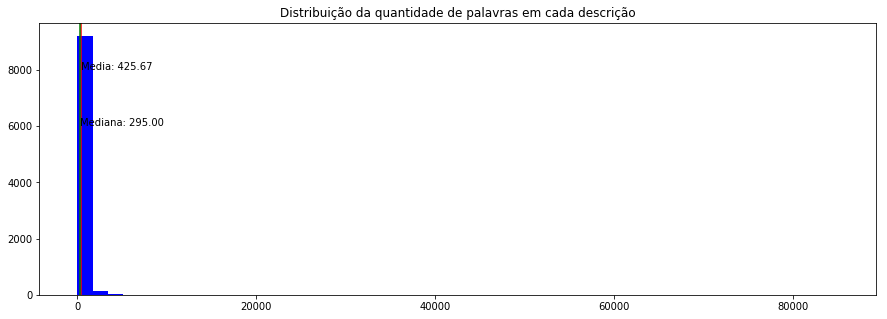

In [11]:
lista_qtd_palavras = base['description'].str.len()

plt.figure(figsize=[15, 5])
plt.title('Distribuição da quantidade de palavras em cada descrição')

plt.axvline(x=mean(lista_qtd_palavras), color='red')
plt.text(mean(lista_qtd_palavras), 8000, 'Media: %.2f' % mean(lista_qtd_palavras))

plt.axvline(x=median(lista_qtd_palavras), color='green')
plt.text(median(lista_qtd_palavras), 6000, 'Mediana: %.2f' % median(lista_qtd_palavras))

plt.hist(lista_qtd_palavras, bins=50, color='blue')
plt.show()

Removendo as descrições com menos de 40 palavras

In [12]:
base['value_counts'] = lista_qtd_palavras
base = base[base['value_counts'] > 40]

In [13]:
base_treino = base[['description']].dropna()
base_treino = base_treino['description'].apply(preprocessing_text)
base_treino = list(base_treino)

## Gerando os produtos similares
A partir do modelo treinado sera gerado uma matriz com a similaridade entre os produtos da base.

#### Treinando o modelo
Aqui geramos o dicionario e treinamos o modelo para podermos ter a similaridade dos produtos

In [14]:
model = Word2Vec(base_treino, window=10, size=150)
model.train(base_treino, total_examples=len(base_treino), epochs=100)

(45963958, 64644200)

Similaridade dos 15 primeiros produtos

In [15]:
matrix = matrix_similarity(base[['description']].head(15), model)

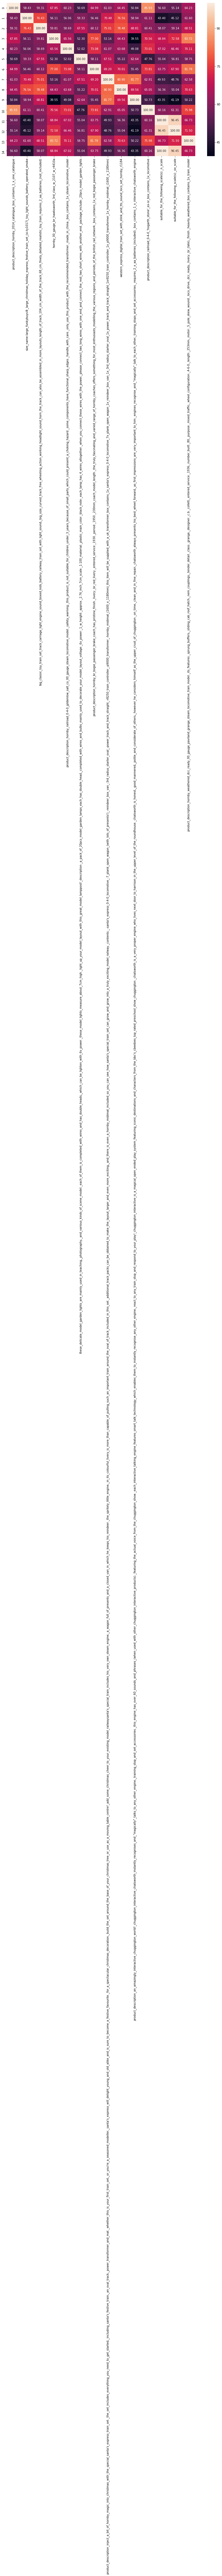

In [16]:
plt.figure(figsize=(15, 10))
heatmap(matrix, annot=True, fmt='.2f')
plt.show()